## Control vs. Everything without UPDRS

From request [New ML Analyses](https://trello.com/c/PWNhnPEw)

Run the following models: 

Control vs. PD
Control vs. MSA
Control vs. PSP 

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 1, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx').drop(['UPDRS'], axis=1)
_random_seed = 55

## 7. Control vs. PD

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.1s finished


Best parameters set found on development set:

{'classifier__C': 2.06913808111479e-05}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.40      1.00      0.57        63
        1.0       0.00      0.00      0.00        95

avg / total       0.16      0.40      0.23       158


Confusion matrix, without normalization
[[63  0]
 [95  0]]

recall	0.0
precision	0.0
auc	0.5
specificity	1.0
npv	0.398734177215
accuracy	0.398734177215


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


weighted_sensitivity	0.0
weighted_ppv	nan
weighted_specificity	1.0
weighted_npv	0.5
weighted_accuracy	0.5


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in double_scalars


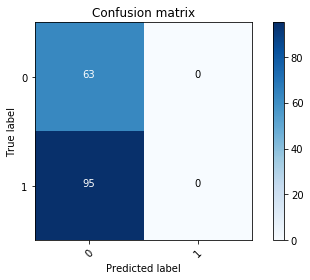

In [3]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [4]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\ana

fit_time	0.187837314606	0.00528684404186
score_time	0.10431265831	0.00364686538108
test_recall	1.0	0.0
train_recall	1.0	0.0
test_precision	0.659267591551	0.00107486564179
train_precision	0.659270784221	0.00027031274556
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	0.0	0.0
train_specificity	0.0	0.0
test_npv	nan	nan
train_npv	nan	nan
test_accuracy	0.659267591551	0.00107486564179
train_accuracy	0.659270784221	0.00027031274556
test_weighted_sensitivity	1.0	0.0
train_weighted_sensitivity	1.0	0.0
test_weighted_ppv	0.5	0.0
train_weighted_ppv	0.5	0.0
test_weighted_specificity	0.0	0.0
train_weighted_specificity	0.0	0.0
test_weighted_npv	nan	nan
train_weighted_npv	nan	nan
test_weighted_accuracy	0.5	0.0
train_weighted_accuracy	0.5	0.0


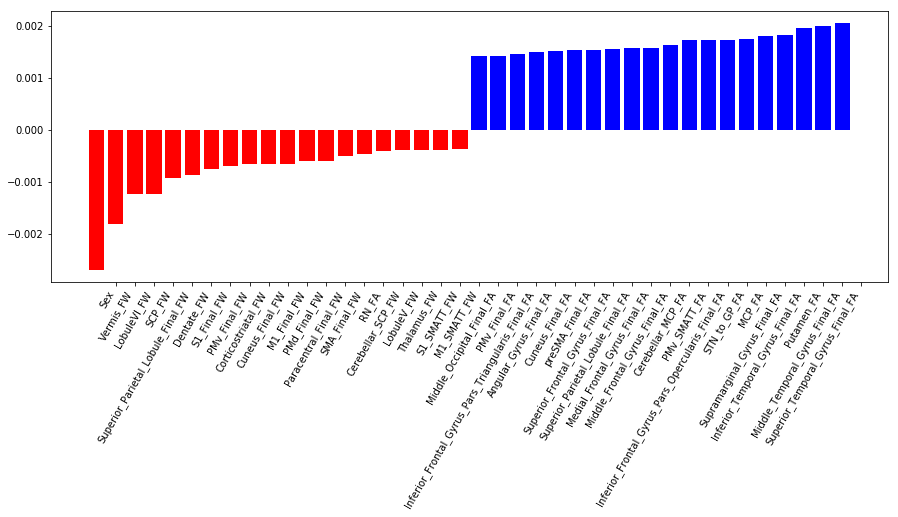

Age	-0.000137485829074
Sex	-0.00270359570934
aSN_FA	0.00116403649009
Caudate_FA	0.000236415045383
CC2_FA	0.00115529599658
GP_FA	0.00104850488415
LobuleVI_FA	0.000440196460389
LobuleV_FA	0.000461845925708
MCP_FA	0.00174934703856
pSN_FA	0.00106500511011
Putamen_FA	0.0019706619749
SCP_FA	0.00125603565117
STN_FA	0.00136573235574
Thalamus_FA	0.00140152451057
Vermis_FA	0.000253375172234
RN_FA	-0.000465424241572
PPN_FA	0.000895690168715
Dentate_FA	0.000685297358885
CC1_FA	0.000901338867731
aSN_FW	0.000473270352904
Caudate_FW	0.00100795316593
CC2_FW	6.42021010993e-05
GP_FW	0.000508926959227
LobuleVI_FW	-0.00123956777321
LobuleV_FW	-0.000396460107348
MCP_FW	0.000195390166758
pSN_FW	0.00135376070481
Putamen_FW	1.29444705977e-05
SCP_FW	-0.00123715087587
STN_FW	-2.36849784673e-05
Thalamus_FW	-0.000394888673843
Vermis_FW	-0.00181088981344
RN_FW	0.000542890634372
PPN_FW	-0.000183629096361
Dentate_FW	-0.000869533828126
CC1_FW	0.00028726295284
Angular_Gyrus_Final_FA	0.00149909578963
Anterior_Orbital_G

In [5]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.40      1.00      0.57        63
        1.0       0.00      0.00      0.00        95

avg / total       0.16      0.40      0.23       158



C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


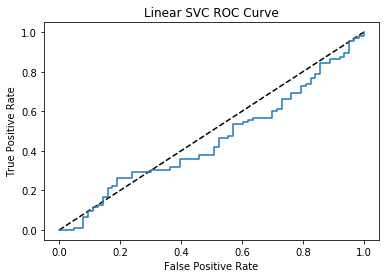

0.0 0.0
0.015873015873 0.0
0.047619047619 0.0
0.047619047619 0.0105263157895
0.0793650793651 0.0105263157895
0.0793650793651 0.0631578947368
0.0952380952381 0.0631578947368
0.0952380952381 0.0947368421053
0.111111111111 0.0947368421053
0.111111111111 0.115789473684
0.126984126984 0.115789473684
0.126984126984 0.126315789474
0.142857142857 0.126315789474
0.142857142857 0.168421052632
0.15873015873 0.168421052632
0.15873015873 0.210526315789
0.174603174603 0.210526315789
0.174603174603 0.221052631579
0.190476190476 0.221052631579
0.190476190476 0.263157894737
0.238095238095 0.263157894737
0.238095238095 0.294736842105
0.301587301587 0.294736842105
0.301587301587 0.305263157895
0.365079365079 0.305263157895
0.365079365079 0.315789473684
0.396825396825 0.315789473684
0.396825396825 0.357894736842
0.460317460317 0.357894736842
0.460317460317 0.378947368421
0.507936507937 0.378947368421
0.507936507937 0.421052631579
0.52380952381 0.421052631579
0.52380952381 0.463157894737
0.555555555556 0.4

In [6]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 8. Control vs MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.95      0.87      0.91        62
        1.0       0.50      0.73      0.59        11

avg / total       0.88      0.85      0.86        73


Confusion matrix, without normalization
[[54  8]
 [ 3  8]]

recall	0.727272727273
precision	0.5
auc	0.799120234604
specificity	0.870967741935
npv	0.947368421053
accuracy	0.849315068493
weighted_sensitivity	0.727272727273
weighted_ppv	0.849315068493
weighted_specificity	0.870967741935
weighted_npv	0.761538461538
weighted_accuracy	0.799120234604


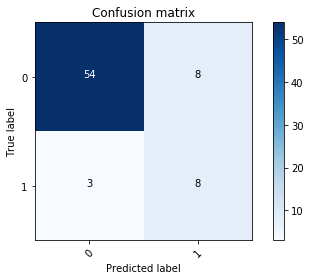

In [7]:
# Get the data
data2 = group_classes(_data, {0:0, 2:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [8]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0241940975189	0.000678284148763
score_time	0.0164053916931	0.000593516462109
test_recall	0.767619047619	0.0284760312147
train_recall	0.883459964933	0.045530918599
test_precision	0.717269937665	0.125164070588
train_precision	0.803022400187	0.0567984521663
test_auc	0.828154132689	0.0319738742154
train_auc	0.904120760797	0.0216467351862
test_specificity	0.888689217759	0.0597897646791
train_specificity	0.924781556661	0.0265829921539
test_npv	0.918667180772	0.00990639312099
train_npv	0.95952230816	0.0147694360852
test_accuracy	0.857759389707	0.0442043184064
train_accuracy	0.914314855559	0.0188162181782
test_weighted_sensitivity	0.767619047619	0.0284760312147
train_weighted_sensitivity	0.883459964933	0.045530918599
test_weighted_ppv	0.877348444599	0.0594287804536
train_weighted_ppv	0.922503993448	0.0246957592965
test_weighted_specificity	0.888689217759	0.0597897646791
train_weighted_specificity	0.924781556661	0.0265829921539
test_weighted_npv	0.792707663964	0.0211633541188
train_w

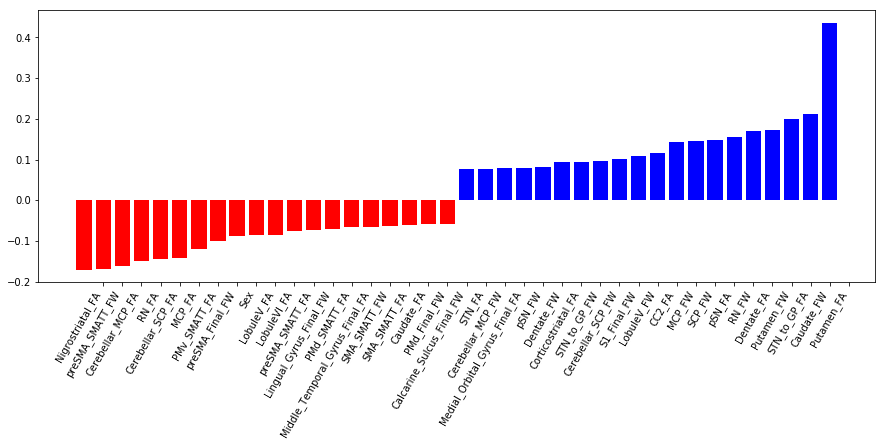

Age	-0.047564936264
Sex	-0.0874667703004
aSN_FA	-0.0220333782973
Caudate_FA	-0.0606569482324
CC2_FA	0.115392499946
GP_FA	0.0305091733112
LobuleVI_FA	-0.0851746314642
LobuleV_FA	-0.0860523005696
MCP_FA	-0.140851037518
pSN_FA	0.147168048962
Putamen_FA	0.435971000521
SCP_FA	-0.0311731237027
STN_FA	0.0768857332302
Thalamus_FA	0.0212229315509
Vermis_FA	-0.00589129139102
RN_FA	-0.14933260797
PPN_FA	0.0479182293221
Dentate_FA	0.169699871109
CC1_FA	-0.0459348413776
aSN_FW	0.0586457063116
Caudate_FW	0.210838859283
CC2_FW	0.0374827353372
GP_FW	0.0630485320264
LobuleVI_FW	0.0150561451706
LobuleV_FW	0.109258460613
MCP_FW	0.142004572037
pSN_FW	0.0796543080689
Putamen_FW	0.171568699217
SCP_FW	0.145820318042
STN_FW	0.0170480726667
Thalamus_FW	-0.0151563025348
Vermis_FW	0.0273611400082
RN_FW	0.15649454812
PPN_FW	-0.0471005002533
Dentate_FW	0.0824095253585
CC1_FW	-0.0334129536026
Angular_Gyrus_Final_FA	-0.0259018572779
Anterior_Orbital_Gyrus_Final_FA	-0.0263437748607
Calcarine_Sulcus_Final_FA	-0.008812

In [9]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.95      0.87      0.91        62
        1.0       0.50      0.73      0.59        11

avg / total       0.88      0.85      0.86        73



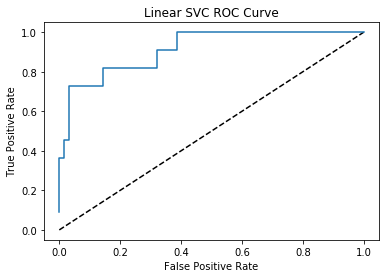

0.0 0.0909090909091
0.0 0.363636363636
0.0161290322581 0.363636363636
0.0161290322581 0.454545454545
0.0322580645161 0.454545454545
0.0322580645161 0.727272727273
0.145161290323 0.727272727273
0.145161290323 0.818181818182
0.322580645161 0.818181818182
0.322580645161 0.909090909091
0.387096774194 0.909090909091
0.387096774194 1.0
1.0 1.0


In [10]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 9. Control vs PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    8.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


Best parameters set found on development set:

{'classifier__C': 0.0069519279617756054}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.91      1.00      0.95        59
        1.0       1.00      0.74      0.85        23

avg / total       0.93      0.93      0.92        82


Confusion matrix, without normalization
[[59  0]
 [ 6 17]]

recall	0.739130434783
precision	1.0
auc	0.869565217391
specificity	1.0
npv	0.907692307692
accuracy	0.926829268293
weighted_sensitivity	0.739130434783
weighted_ppv	1.0
weighted_specificity	1.0
weighted_npv	0.793103448276
weighted_accuracy	0.869565217391


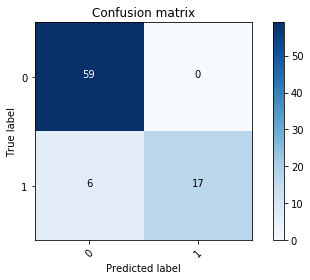

In [11]:
# Get the data
data3 = group_classes(_data, {0:0, 3:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [12]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0249960899353	0.000947373621826
score_time	0.015918636322	0.000411625478062
test_recall	0.849350649351	0.0544422854451
train_recall	0.884425770308	0.00889610453391
test_precision	0.908847117794	0.0393112862615
train_precision	0.93566017316	0.0196032688734
test_auc	0.904115070976	0.0339169177687
train_auc	0.927375222816	0.00603758896599
test_specificity	0.9588794926	0.0170691814148
train_specificity	0.970324675325	0.00981340500853
test_npv	0.929634872486	0.0245433246542
train_npv	0.94551790904	0.00380082298935
test_accuracy	0.923164335664	0.0272661144933
train_accuracy	0.942319185423	0.0067817647393
test_weighted_sensitivity	0.849350649351	0.0544422854451
train_weighted_sensitivity	0.884425770308	0.00889610453391
test_weighted_ppv	0.953200363018	0.0210903711806
train_weighted_ppv	0.967659238961	0.0102546421166
test_weighted_specificity	0.9588794926	0.0170691814148
train_weighted_specificity	0.970324675325	0.00981340500853
test_weighted_npv	0.865867243551	0.0434931854097
train

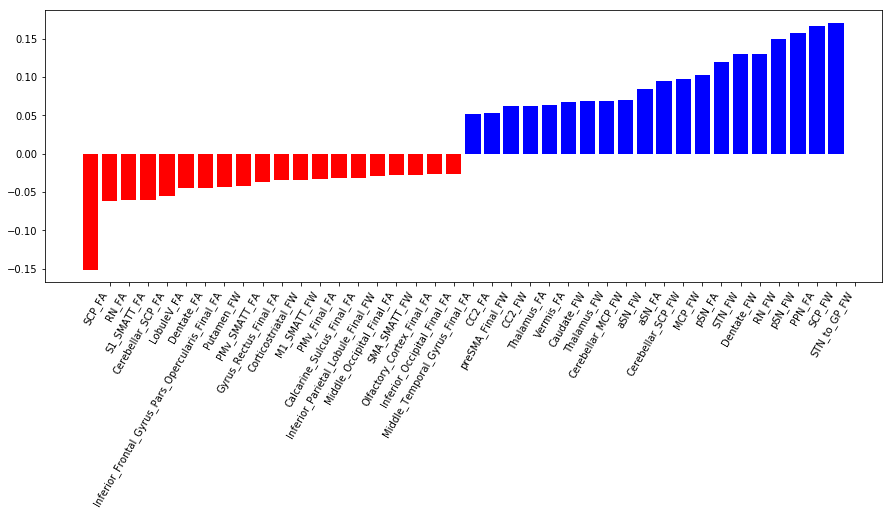

Age	-0.0257560620551
Sex	-0.013809599925
aSN_FA	0.0844619106522
Caudate_FA	0.0262355032014
CC2_FA	0.0517596000083
GP_FA	0.0191771117659
LobuleVI_FA	0.00845181173161
LobuleV_FA	-0.0549428317104
MCP_FA	0.0174570469013
pSN_FA	0.102181359225
Putamen_FA	-0.00405949777952
SCP_FA	-0.151394283314
STN_FA	0.0283029312627
Thalamus_FA	0.0621749920651
Vermis_FA	0.0635678848418
RN_FA	-0.0620879068186
PPN_FA	0.156597273902
Dentate_FA	-0.045097874627
CC1_FA	0.0413065556215
aSN_FW	0.0698763891218
Caudate_FW	0.0676694629829
CC2_FW	0.0615549925106
GP_FW	0.00478745851436
LobuleVI_FW	0.034715334612
LobuleV_FW	0.0289110693616
MCP_FW	0.097294355357
pSN_FW	0.149226013668
Putamen_FW	-0.0435959310237
SCP_FW	0.166205561127
STN_FW	0.118940268773
Thalamus_FW	0.0679909478925
Vermis_FW	-0.0137046541734
RN_FW	0.130470069037
PPN_FW	0.0434289365486
Dentate_FW	0.129776514775
CC1_FW	-0.0129805267066
Angular_Gyrus_Final_FA	0.0292139864435
Anterior_Orbital_Gyrus_Final_FA	-0.00473878170098
Calcarine_Sulcus_Final_FA	-0.03185

In [13]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.91      1.00      0.95        59
        1.0       1.00      0.74      0.85        23

avg / total       0.93      0.93      0.92        82



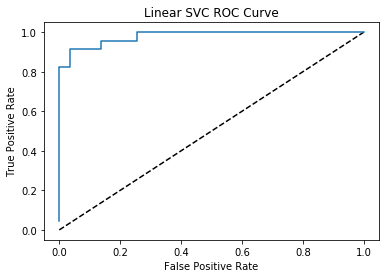

0.0 0.0434782608696
0.0 0.826086956522
0.0338983050847 0.826086956522
0.0338983050847 0.913043478261
0.135593220339 0.913043478261
0.135593220339 0.95652173913
0.254237288136 0.95652173913
0.254237288136 1.0
1.0 1.0


In [14]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)